<a href="https://colab.research.google.com/github/Malekkamoua/PFE/blob/main/5_Forecasting%20%7C%20ML_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

drive.mount('/content/gdrive')

Mounted at /content/gdrive


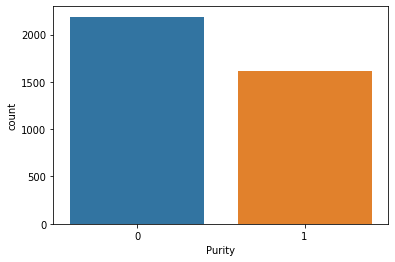

In [6]:
df = pd.read_csv('/content/gdrive/MyDrive/Datascience/PFE/datasets/final.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)

sns.countplot(x ='Purity', data = df)
plt.show()

In [7]:
df.columns

Index(['dates', '% Silica Feed', 'Amina Flow', 'Flotation Column 01 Air Flow',
       'Flotation Column 03 Air Flow', 'Flotation Column 04 Air Flow',
       'Flotation Column 02 Level', 'Flotation Column 03 Level',
       '% Iron Concentrate', '% Silica Concentrate', 'Purity'],
      dtype='object')

In [8]:
features = ['% Silica Feed', 'Amina Flow', 'Flotation Column 01 Air Flow',
       'Flotation Column 03 Air Flow', 'Flotation Column 04 Air Flow',
       'Flotation Column 02 Level', 'Flotation Column 03 Level',
       '% Iron Concentrate']

label = '% Silica Concentrate'
test_df = df[df['dates'] >= '2017-07-01']
train_df = df[df['dates'] < '2017-07-01']
X_train, y_train = train_df[features], train_df[label]
X_test, y_test = test_df[features], test_df[label]

In [31]:
from xgboost import XGBRegressor

reg = XGBRegressor(n_estimators=300, learning_rate=0.01)
reg.fit(X_train, 
        y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        eval_metric='mae')

[22:07:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:2.52516	validation_1-mae:2.13719
[1]	validation_0-mae:2.49996	validation_1-mae:2.11211
[2]	validation_0-mae:2.47502	validation_1-mae:2.08813
[3]	validation_0-mae:2.45033	validation_1-mae:2.06438
[4]	validation_0-mae:2.42589	validation_1-mae:2.04087
[5]	validation_0-mae:2.40169	validation_1-mae:2.0176
[6]	validation_0-mae:2.37773	validation_1-mae:1.99456
[7]	validation_0-mae:2.354	validation_1-mae:1.97092
[8]	validation_0-mae:2.33053	validation_1-mae:1.94833
[9]	validation_0-mae:2.30728	validation_1-mae:1.92598
[10]	validation_0-mae:2.28425	validation_1-mae:1.90384
[11]	validation_0-mae:2.26147	validation_1-mae:1.88193
[12]	validation_0-mae:2.23891	validation_1-mae:1.86023
[13]	validation_0-mae:2.21657	validation_1-mae:1.83864
[14]	validation_0-mae:2.19446	validation_1-mae:1.81739
[15]	validation_0-mae:2.17257	validation_1-mae:1.79624
[16]	v

XGBRegressor(learning_rate=0.01, n_estimators=300)

In [32]:
predictions = reg.predict(X_test)
test_df = test_df.reset_index().drop('index', axis=1)
test_df['predictions'] = pd.Series(predictions)

Test RMSE: 0.729


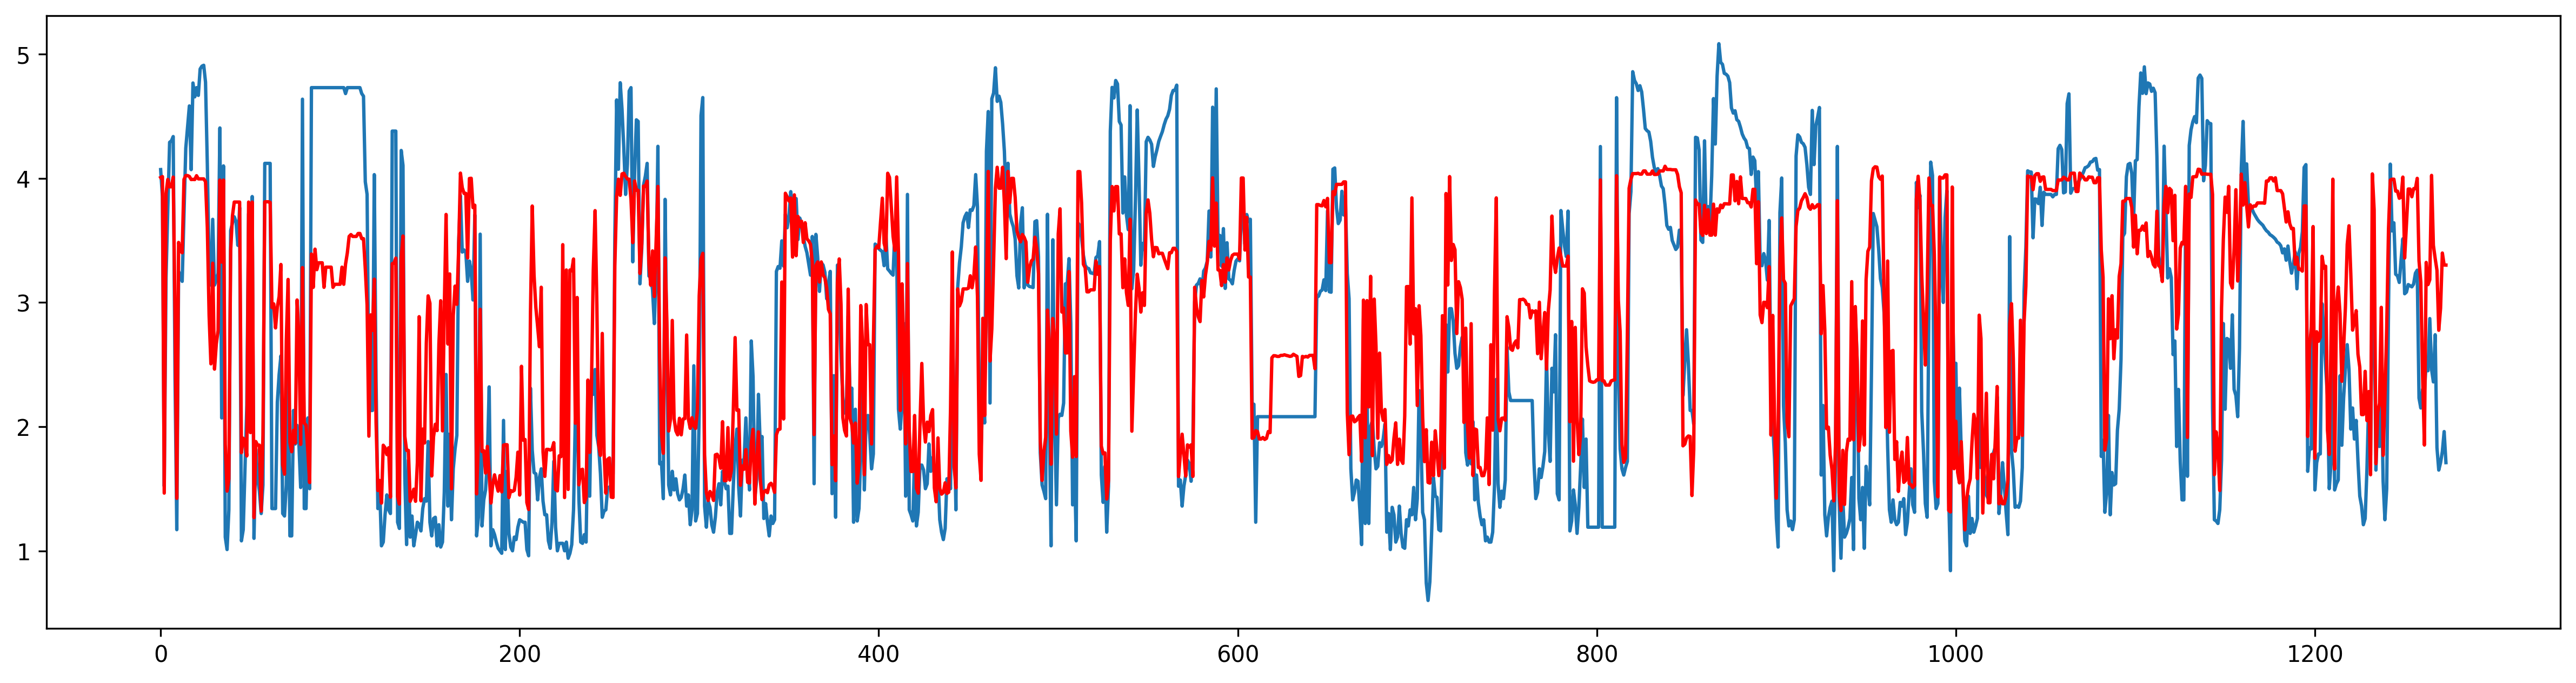

In [33]:
from matplotlib import pyplot
from math import sqrt
from sklearn.metrics import mean_squared_error

fig, ax = plt.subplots(figsize=(20,5))

# evaluate forecasts
rmse = sqrt(mean_squared_error(test_df['% Silica Concentrate'], predictions))
print('Test RMSE: %.3f' % rmse)

# plot forecasts against actual outcomes
pyplot.plot(test_df['% Silica Concentrate'])
pyplot.plot(predictions, color='red')
pyplot.show()